In [24]:
!mkdir data


In [ ]:
!kaggle competitions download -c rsna-intracranial-hemorrhage-detection

In [ ]:
!unzip rsna-intracranial-hemorrhage-detection.zip -d data

In [ ]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt

import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from fastai.vision import *

In [3]:
DATA = Path("data/rsna-intracranial-hemorrhage-detection")

In [4]:
df = pd.read_csv('data/rsna-intracranial-hemorrhage-detection/stage_1_train.csv')

In [86]:
df.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [88]:

newtable = df.copy()

In [89]:
new = newtable["ID"].str.split("_", n = 1, expand = True)
newX = new[1].str.split("_", n = 1, expand = True)
newX[1]
newtable['Image_ID'] = newX[0]
newtable['Sub_type'] = newX[1]
newtable.head()

,ID,Label,Image_ID,Sub_type
0,ID_63eb1e259_epidural,0,63eb1e259,epidural
1,ID_63eb1e259_intraparenchymal,0,63eb1e259,intraparenchymal
2,ID_63eb1e259_intraventricular,0,63eb1e259,intraventricular
3,ID_63eb1e259_subarachnoid,0,63eb1e259,subarachnoid
4,ID_63eb1e259_subdural,0,63eb1e259,subdural


In [7]:
image_ids = newtable.Image_ID.unique()
labels = ["" for _ in range(len(image_ids))]
new_df = pd.DataFrame(np.array([image_ids, labels]).transpose(), columns=["id", "labels"])

In [12]:
lbls = {i : "" for i in image_ids}

In [13]:
newtable = newtable[newtable.Label == 1]
newtable = newtable[newtable.Sub_type != "any"]

i = 0
for name, group in newtable.groupby("Image_ID"):
    lbls[name] = " ".join(group.Sub_type)
    if i % 10000 == 0: print(i)
    i += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [14]:
new_df = pd.DataFrame(np.array([list(lbls.keys()), list(lbls.values())]).transpose(), columns=["id", "labels"])

In [18]:
del lbls
del newtable
del newX
del new
gc.collect()

128

In [19]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [20]:
new_df.id = "ID_" + new_df.id + ".dcm"

In [25]:
def new_open_image(path, div=True, convert_mode=None, after_open=None):
    dcm = pydicom.dcmread(str(path))
    window_center, window_width, intercept, slope = get_windowing(dcm)
    im = window_image(dcm.pixel_array, window_center, window_width, intercept, slope)
    im = np.stack((im,)*3, axis=-1)
    im -= im.min()
    im_max = im.max()
    if im_max != 0: im = im / im.max()
    x = Image(pil2tensor(im, dtype=np.float32))
    #if div: x.div_(2048)  # ??
    return x


vision.data.open_image = new_open_image

In [26]:
df_train = pd.concat([new_df[new_df.labels == ""][:15000], new_df[new_df.labels != ""][:15000]])

In [73]:
torch.cuda.empty_cache()

bs = 64

im_list = ImageList.from_df(df_train, path=DATA/"stage_1_train_images")
test_fnames = pd.DataFrame("ID_" + pd.read_csv(DATA/"stage_1_sample_submission.csv")["ID"].str.split("_", n=2, expand = True)[1].unique() + ".dcm")
test_im_list = ImageList.from_df(test_fnames, path=DATA/"stage_1_test_images")

tfms = get_transforms(do_flip=False)

data = (im_list.split_by_rand_pct(0.2)
               .label_from_df(label_delim=" ")
               .transform(tfms, size=256)
               .add_test(test_im_list)
               .databunch(bs=bs, num_workers=0)
               .normalize())

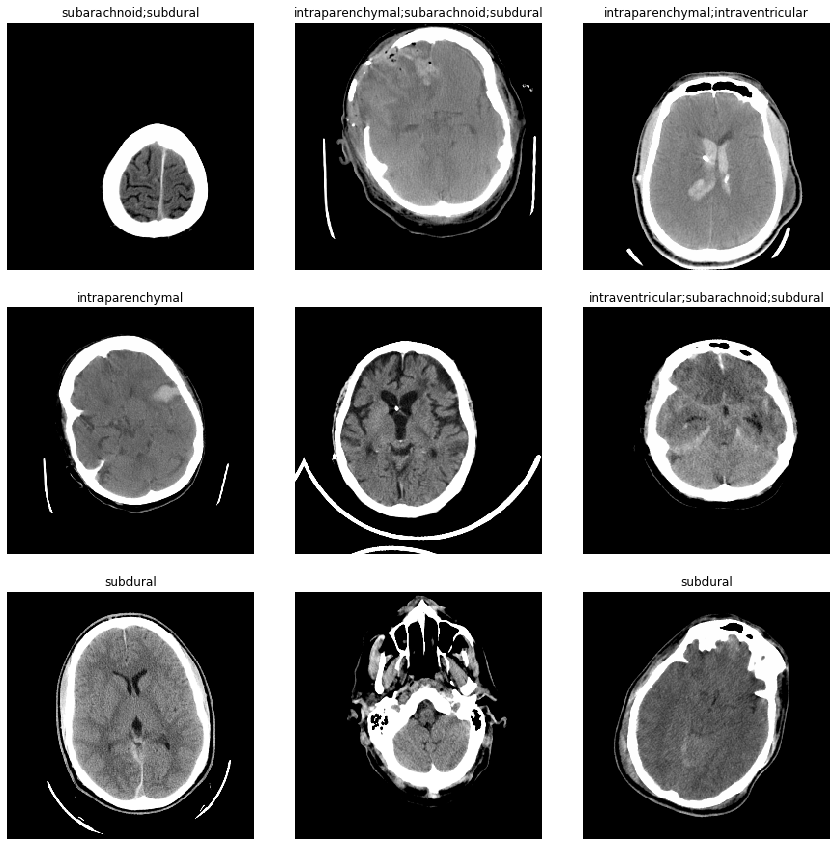

In [74]:
data.show_batch(3)

In [75]:
learn = cnn_learner(data, models.resnet50)
learn.metrics = [accuracy_thresh]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


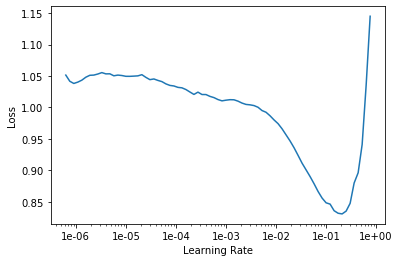

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.262034,0.243705,0.899200,04:37


In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [ ]:
learn.fit_one_cycle(20, slice(1e-3))

In [78]:
submission = pd.read_csv(DATA/"stage_1_sample_submission.csv")
submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5


In [80]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [81]:
preds = np.array(preds[0])

In [82]:
any_probs = 1 - np.prod(1 - preds, axis=1)

In [83]:
submission.Label = np.hstack([preds, np.expand_dims(any_probs, -1)]).reshape(-1)

In [84]:
submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.004981
1,ID_28fbab7eb_intraparenchymal,0.013210
2,ID_28fbab7eb_intraventricular,0.003238
3,ID_28fbab7eb_subarachnoid,0.018500
4,ID_28fbab7eb_subdural,0.068090


In [85]:
submission.to_csv("submission.csv", index=False)